# Introduction

## Who Am I?

## What is Dask?
Comparative with other libraries as 

* [Modin](https://github.com/modin-project/modin)
* [Vaex](https://vaex.readthedocs.io/)
* [Spark](https://spark.apache.org/)

## Dask Cluster instead of [AWS lambda](https://aws.amazon.com/lambda/)
Focus on costs


# Environment

## Load 
```bash
conda env create -f env_environment.yml
```

## List of packages
```bash
conda create -n pydata_stg python=3.7 --channel conda-forge
conda activate pydata_stg
conda config --env --add channels conda-forge
conda install dask
conda install pyarrow
conda install python-graphviz
conda install holidays
conda install ipykernel
pip install d6tstack # make a conda package
python -m ipykernel install --user --name pydata_stg
```

# Examples

* [holidays](https://stackoverflow.com/questions/56106470/how-to-add-column-in-dask-dataframe-that-reflecs-whether-date-value-from-column/56114344#56114344)
* [np.deg2rad](https://stackoverflow.com/questions/52295301/parallel-computation-with-dask-when-dataframe-column-needs-to-be-computed/52303939#52303939)           

# Parallelize computation

## `multiprocessing`

In [1]:
import time
import multiprocessing as mp


def parallelize(fun, vec, cores=mp.cpu_count()):
    with mp.Pool(cores) as p:
        res = p.map(fun, vec)
    return res


def parallelize_multi(fun, vec, cores=mp.cpu_count()):
    with mp.Pool(processes=cores) as p:
        res = p.starmap(fun, vec)
    return res

In [2]:
def fun1(x):
    time.sleep(1)
    return x


def fun2(x, y):
    time.sleep(1)
    return x+y


def fun2_1(x):
    time.sleep(1)
    return x[0]+x[1]

In [3]:
cores = mp.cpu_count()
vec1 = list(range(2*cores))
vec2 = [(v, 2) for v in vec1]
print(len(vec1))

8


In [4]:
%%time
out1 = [fun1(v) for v in vec1]

CPU times: user 2.15 ms, sys: 272 µs, total: 2.42 ms
Wall time: 8.01 s


In [5]:
out1

[0, 1, 2, 3, 4, 5, 6, 7]

In [6]:
%%time
out2 = [fun2(v[0],v[1]) for v in vec2]

CPU times: user 2.18 ms, sys: 126 µs, total: 2.3 ms
Wall time: 8.01 s


In [7]:
out2

[2, 3, 4, 5, 6, 7, 8, 9]

In [8]:
%%time
out1 = parallelize(fun1, vec1)

CPU times: user 24.8 ms, sys: 4.11 ms, total: 28.9 ms
Wall time: 2.14 s


In [9]:
out1

[0, 1, 2, 3, 4, 5, 6, 7]

In [10]:
%%time
out2 = parallelize_multi(fun2, vec2)

CPU times: user 2.25 ms, sys: 20.7 ms, total: 22.9 ms
Wall time: 2.03 s


In [11]:
out2

[2, 3, 4, 5, 6, 7, 8, 9]

In [12]:
%%time
out2 = parallelize(fun2_1, vec2)

CPU times: user 5.45 ms, sys: 20 ms, total: 25.5 ms
Wall time: 2.13 s


In [13]:
out2

[2, 3, 4, 5, 6, 7, 8, 9]

## `dask.delayed`

In [14]:
from dask import delayed, compute

In [15]:
%%time
to_process1 = [delayed(fun1)(v) for v in vec1]

CPU times: user 2.46 ms, sys: 364 µs, total: 2.83 ms
Wall time: 1.92 ms


In [16]:
to_process1

[Delayed('fun1-bb177a32-3a3f-4e1d-9047-0d892a3cc455'),
 Delayed('fun1-3aa0f565-d22b-4175-8023-62f2122911e6'),
 Delayed('fun1-c6b1c0fc-f4bd-47d3-bcc4-da1191f973e2'),
 Delayed('fun1-66ef833f-f396-4dab-9b1d-c259025437cf'),
 Delayed('fun1-fb68a7cb-f52f-4906-8d59-ccd806e4bfbe'),
 Delayed('fun1-b31ef3a2-fb0b-4167-8090-8001974b3f3d'),
 Delayed('fun1-66a52480-e876-465f-980f-9e6815051290'),
 Delayed('fun1-2c79d6c7-5c44-48eb-a876-1c2acb59913b')]

In [17]:
%%time
to_process1 = [delayed(fun1)(v) for v in vec1]
out1 = compute(to_process1)

CPU times: user 15 ms, sys: 411 µs, total: 15.4 ms
Wall time: 2.05 s


In [18]:
out1

([0, 1, 2, 3, 4, 5, 6, 7],)

In [19]:
%%time
to_process2 = [delayed(fun2)(v[0],v[1]) for v in vec2]
out2 = compute(to_process2)

CPU times: user 11 ms, sys: 407 µs, total: 11.4 ms
Wall time: 2.01 s


In [20]:
out2

([2, 3, 4, 5, 6, 7, 8, 9],)

Example using decorator `@delayed`.


This can eventually run on a cluster!

# Dataframes

## Generate dummy dataset

In [1]:
import numpy as np
import os
import pandas as pd
import shutil
import dask.dataframe as dd
from dask import delayed, compute
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44089 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.52 GB


In [2]:
fldr_raw = "datasets/dummy/raw"
os.makedirs(fldr_raw, exist_ok=True)

In [3]:
def generate_df(n, N):
    df = pd.DataFrame({"id":np.random.randint(10,100,N),
                       "value":np.random.rand(N),
                       "lat":np.random.uniform(low=-90, high=90, size=N),
                       "lon":np.random.uniform(low=-180, high=180,size=N)})
    df["value1"] = df["id"]*df["value"]
    fn = f'{fldr_raw}/file_{n:02d}.csv'
    df.to_csv(fn, index=False)

In [4]:
N = int(1e6)

In [5]:
%%time
generate_df(1,N)

CPU times: user 10.5 s, sys: 482 ms, total: 11 s
Wall time: 10.8 s


In [6]:
@delayed
def generate_df(n, N):
    df = pd.DataFrame({"id":np.random.randint(10,100,N),
                       "value":np.random.rand(N),
                       "lat":np.random.uniform(low=-90, high=90, size=N),
                       "lon":np.random.uniform(low=-180, high=180,size=N)})
    df["value1"] = df["id"]*df["value"]
    fn = f'{fldr_raw}/file_{n:02d}.csv'
    df.to_csv(fn, index=False)

In [8]:
shutil.rmtree(fldr_raw)
os.makedirs(fldr_raw, exist_ok=True)

In [9]:
%%time
to_process = [generate_df(i, N) for i in range(20)]
out = compute(to_process)

CPU times: user 6.31 s, sys: 823 ms, total: 7.13 s
Wall time: 1min 41s


## Read

In [10]:
client.restart()

Client Scheduler: tcp://127.0.0.1:39015 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.52 GB


In [8]:
df = dd.read_csv("datasets/dummy/raw/*.csv")

In [9]:
df

,id,value,lat,lon,value1
npartitions=40,,,,,
,int64,float64,float64,float64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [10]:
df.head()

,id,value,lat,lon,value1
0,80,0.772008,-34.769415,-172.250288,61.760662
1,85,0.227687,-36.786150,60.872459,19.353404
2,97,0.676615,74.933042,114.004453,65.631618
3,72,0.557655,15.397291,-21.091304,40.151161
4,14,0.196189,52.658036,-136.913529,2.746646


In [11]:
%%time
df = df.compute()

CPU times: user 2.32 s, sys: 1.86 s, total: 4.18 s
Wall time: 12.5 s


## Aggregations

In [7]:
df = dd.read_csv("datasets/dummy/raw/*.csv")

In [8]:
%%time
out = df.groupby("id")["value1"].mean()

CPU times: user 17.5 ms, sys: 363 µs, total: 17.8 ms
Wall time: 17.1 ms


In [9]:
out

Dask Series Structure:
npartitions=1
    float64
        ...
Name: value1, dtype: float64
Dask Name: truediv, 213 tasks

In [10]:
%%time
out = out.compute()

CPU times: user 2.19 s, sys: 209 ms, total: 2.4 s
Wall time: 11.8 s


## Convert to parquet

In [13]:
jobs = []
fldr_in = "datasets/dummy/raw"
for (dirpath, dirnames, filenames) in os.walk(fldr_in):
    if len(filenames) > 0:
        jobs += [os.path.join(dirpath, fn)
                 for fn in filenames]
jobs = sorted(jobs)

In [14]:
jobs[:5]

['datasets/dummy/raw/file_00.csv',
 'datasets/dummy/raw/file_01.csv',
 'datasets/dummy/raw/file_02.csv',
 'datasets/dummy/raw/file_03.csv',
 'datasets/dummy/raw/file_04.csv']

In [19]:
fldr_out = "datasets/dummy/raw_parquet"
os.makedirs(fldr_out, exist_ok=True)

In [20]:
@delayed
def convert2parquet(fn, fldr_in, fldr_out):
    fn_out = fn.replace(fldr_in, fldr_out)\
               .replace(".csv", ".parquet")
    df = pd.read_csv(fn)
    df.to_parquet(fn_out, index=False)

In [21]:
%%time
to_process = [convert2parquet(fn, fldr_in, fldr_out) for fn in jobs]
out = compute(to_process)

CPU times: user 1.39 s, sys: 127 ms, total: 1.52 s
Wall time: 10.6 s


## Aggregate 2

In [26]:
%%time
df = dd.read_parquet("datasets/dummy/raw_parquet/",
                     columns=["id", "value1"])

CPU times: user 47.6 ms, sys: 0 ns, total: 47.6 ms
Wall time: 50.7 ms


In [29]:
df

,id,value1
npartitions=20,,
,int64,float64
,...,...
...,...,...
,...,...
,...,...


In [30]:
%%time
out = df.groupby("id")["value1"].mean()
out = out.compute()

CPU times: user 524 ms, sys: 41.5 ms, total: 565 ms
Wall time: 1.44 s


In [33]:
%%bash
du -h datasets/dummy/raw/
du -h datasets/dummy/raw_parquet/

1.5G	datasets/dummy/raw/
649M	datasets/dummy/raw_parquet/


In [34]:
%%time
df = dd.read_parquet("datasets/dummy/raw_parquet/",
                     columns=["value1"])

CPU times: user 64.5 ms, sys: 0 ns, total: 64.5 ms
Wall time: 62.8 ms


In [36]:
out = df["value1"].sum()

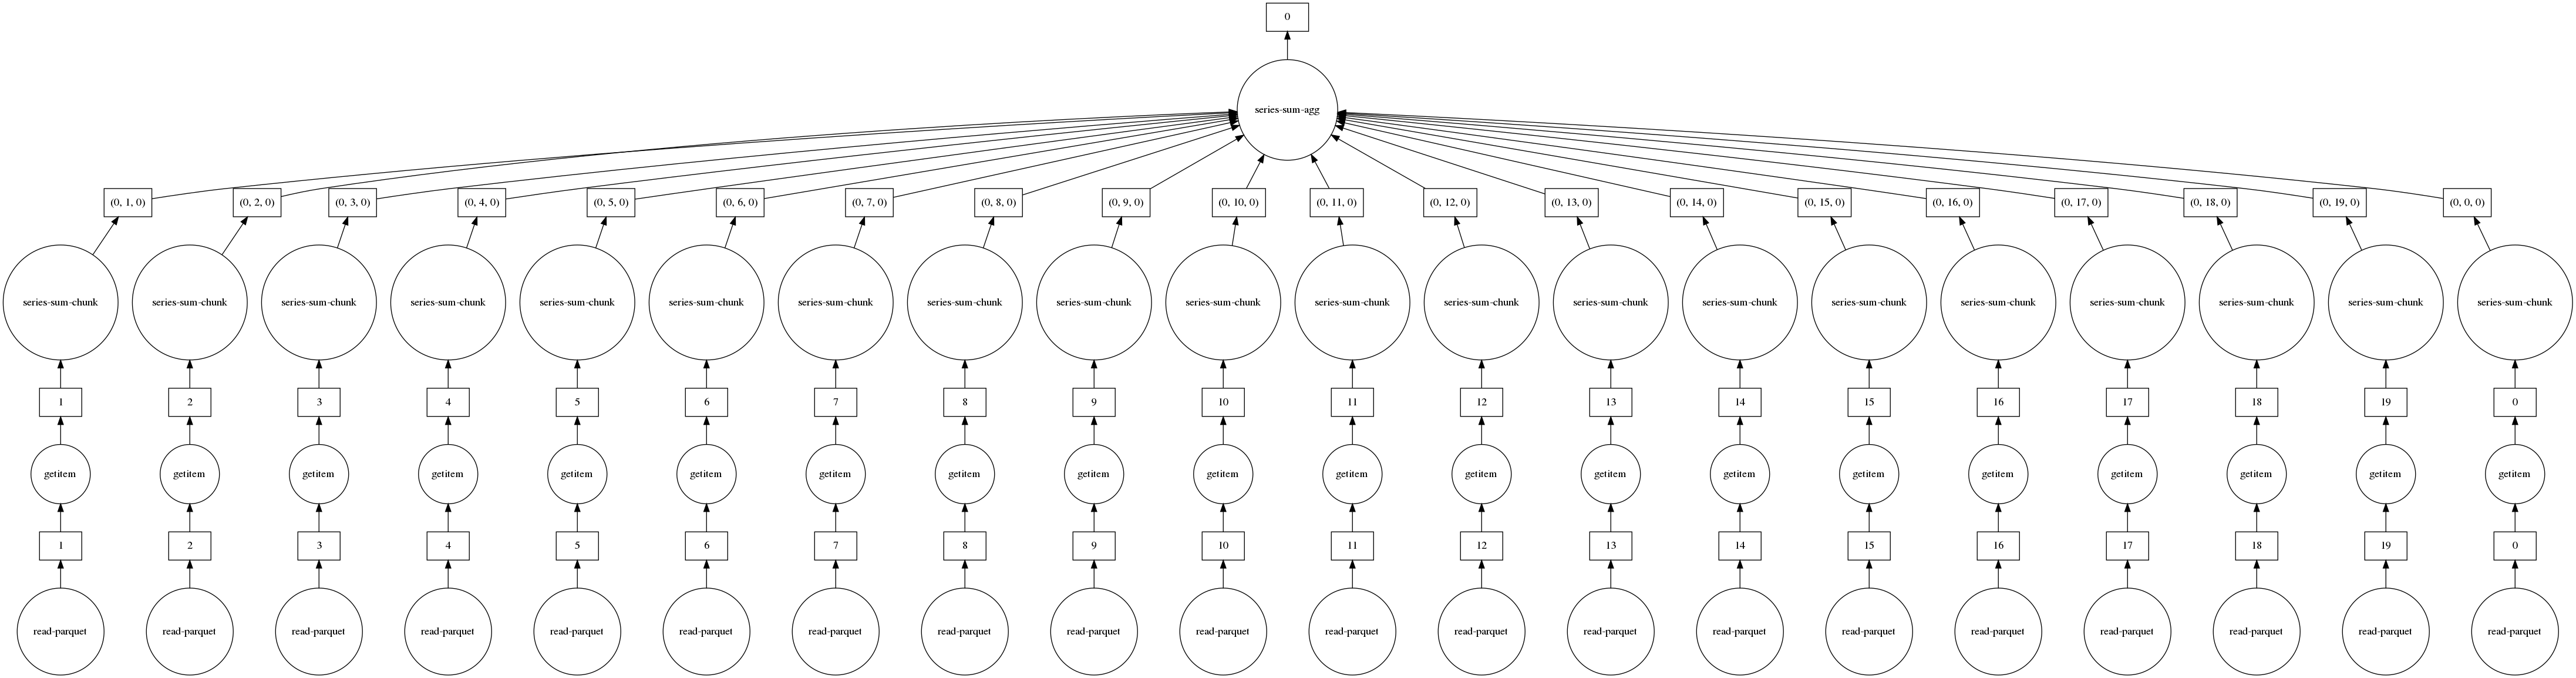

In [38]:
out.visualize()

## Add column

In [2]:
%%time
df = dd.read_parquet("datasets/dummy/raw_parquet/")

CPU times: user 59.6 ms, sys: 4.61 ms, total: 64.2 ms
Wall time: 62.9 ms


In [3]:
df["sum"] = df["value"]+ df["value1"]

In [4]:
df.head()

,id,value,lat,lon,value1,sum
0,80,0.772008,-34.769415,-172.250288,61.760662,62.532670
1,85,0.227687,-36.786150,60.872459,19.353404,19.581091
2,97,0.676615,74.933042,114.004453,65.631618,66.308233
3,72,0.557655,15.397291,-21.091304,40.151161,40.708816
4,14,0.196189,52.658036,-136.913529,2.746646,2.942834


In [6]:
%%time
df.to_parquet("datasets/dummy/out1", write_index=False)

CPU times: user 1.34 s, sys: 113 ms, total: 1.46 s
Wall time: 7.49 s


## Conditional function

In [5]:
def fun(row):
    if row["lat"]<0:
        return row["value"]
    else:
        return row["value1"]

### `apply` DON'T REPRODUCE!

In [4]:
%%time
df = dd.read_parquet("datasets/dummy/raw_parquet/")

CPU times: user 45.3 ms, sys: 0 ns, total: 45.3 ms
Wall time: 45.8 ms


In [6]:
df["a"] = df.apply(fun, axis=1, meta="f8")

In [7]:
df.head()

,id,value,lat,lon,value1,a
0,80,0.772008,-34.769415,-172.250288,61.760662,0.772008
1,85,0.227687,-36.786150,60.872459,19.353404,0.227687
2,97,0.676615,74.933042,114.004453,65.631618,65.631618
3,72,0.557655,15.397291,-21.091304,40.151161,40.151161
4,14,0.196189,52.658036,-136.913529,2.746646,2.746646


In [8]:
%%time
df.to_parquet("datasets/dummy/out2", write_index=False)

CPU times: user 28.5 s, sys: 2.94 s, total: 31.4 s
Wall time: 5min 54s


In [9]:
df = pd.read_parquet("datasets/dummy/out2")

In [10]:
df.head()

,id,value,lat,lon,value1,a
0,80,0.772008,-34.769415,-172.250288,61.760662,0.772008
1,85,0.227687,-36.786150,60.872459,19.353404,0.227687
2,97,0.676615,74.933042,114.004453,65.631618,65.631618
3,72,0.557655,15.397291,-21.091304,40.151161,40.151161
4,14,0.196189,52.658036,-136.913529,2.746646,2.746646


### `map_partition` DON'T REPRODUCE

In [11]:
%%time
df = dd.read_parquet("datasets/dummy/raw_parquet/")

CPU times: user 47.5 ms, sys: 2.54 ms, total: 50 ms
Wall time: 50 ms


In [25]:
df.dtypes.to_dict()

{'id': dtype('int64'),
 'value': dtype('float64'),
 'lat': dtype('float64'),
 'lon': dtype('float64'),
 'value1': dtype('float64')}

In [28]:
df = df.map_partitions(lambda x: x.assign(a=x.apply(fun, axis=1)),
                       meta={'id': 'i8',
                             'value': 'f8',
                             'lat': 'f8',
                             'lon': 'f8',
                             'value1': 'f8',
                             'a':'f8'})

In [30]:
%%time
df.to_parquet("datasets/dummy/out3", write_index=False)

CPU times: user 32.7 s, sys: 1.01 s, total: 33.7 s
Wall time: 6min 6s


### Use mask

In [53]:
%%time
df = dd.read_parquet("datasets/dummy/raw_parquet/")

CPU times: user 42.1 ms, sys: 3.22 ms, total: 45.3 ms
Wall time: 44 ms


In [54]:
df["a"] = (df["lat"]<0)*df["value"]+(df["lat"]>=0)*df["value1"]

In [55]:
%%time
df.to_parquet("datasets/dummy/out4", write_index=False)

CPU times: user 1.24 s, sys: 104 ms, total: 1.34 s
Wall time: 6.03 s


In [56]:
df.head()

,id,value,lat,lon,value1,a
0,80,0.772008,-34.769415,-172.250288,61.760662,0.772008
1,85,0.227687,-36.786150,60.872459,19.353404,0.227687
2,97,0.676615,74.933042,114.004453,65.631618,65.631618
3,72,0.557655,15.397291,-21.091304,40.151161,40.151161
4,14,0.196189,52.658036,-136.913529,2.746646,2.746646


## Again `map_partition`

In [62]:
%%time
df = dd.read_parquet("datasets/dummy/raw_parquet/")

CPU times: user 45.1 ms, sys: 565 µs, total: 45.6 ms
Wall time: 43.1 ms


In [63]:
%%time
df = df.map_partitions(lambda x: x.assign(lat_rad=np.deg2rad(x['lat'].values),
                                          lon_rad=np.deg2rad(x['lon'].values)),

                        meta={'id': 'i8',
                             'value': 'f8',
                             'lat': 'f8',
                             'lon': 'f8',
                             'value1': 'f8',
                             'lat_rad': 'f8',
                             'lon_rad': 'f8'})

CPU times: user 18.5 ms, sys: 385 µs, total: 18.9 ms
Wall time: 18.3 ms


In [64]:
%%time
df.to_parquet("datasets/dummy/out5", write_index=False)

CPU times: user 1.25 s, sys: 120 ms, total: 1.37 s
Wall time: 6.47 s


# About Scheme

# Costs

* 2000 AWS lambda with 3GB RAM running 3 minutes each cost ~17.62 USD
* 2000 n1-standard-1 on GCP with 3.75GB RAM running 3 minutes each cosr ~4.74 USD
